# Traditional Augmentation
- In this notebook, we will be applying a data-centric approach on our baseline model. We will be using Traditional Augmentation techniques, such as Center Crop, Rotate, Color Shift, Flip, etc in this kernel.
- We will be applying these techniques in 3 different ways. Firstly, we will apply these techniques on 25% of the samples from the training dataset irrespective of their classes, and then observe the accuracy of the baseline model after training it on the augmented dataset.
- Secondly, we will be using these techniques for class balancing, and then, will train the baseline model on the balanced dataset.
- Thirdly, we will be analysing the class-wise performance of the baseline model, and will apply augmentation on only those classes on which the baseline model is not performing well.

# 1. Importing the Packages & Boilerplate Code

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from shutil import copyfile
from tabulate import tabulate
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import tensorflow.keras.layers as tfl

In [2]:
# Setting the seeds
SEED = 0
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Making sure that Tensorflow is able to detect the GPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Defining a function to list the memory consumed
# Only outputs variables taking at least 1MB space
def list_storage(inp_dir):
    # Get a sorted list of the objects and their sizes
    vars_defined = [x for x in inp_dir if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    sto = sorted([(x, sys.getsizeof(globals().get(x))) for x in vars_defined], key=lambda x: x[1], reverse=True)
    sto = [(x[0], str(round((x[1] / 2**20), 2)) + ' MB') for x in sto if x[1] >= 2**20]
    print(tabulate(sto, headers = ['Variable', 'Storage (in MB)']))

# In order to use this function, use the below line of code
# list_storage(dir())

# 2. Importing the Train/Test Sets

In [5]:
# Importing the Labelled Dataset
df_train = pd.read_csv("../input/cifar10/train_lab_x.csv")
y_train = pd.read_csv("../input/cifar10/train_lab_y.csv")
df_train = np.array(df_train)
y_train = np.array(y_train)
print(df_train.shape, y_train.shape)

# Reshaping the dataset
df_train = np.reshape(df_train, (-1, 3, 32, 32))
print(df_train.shape)

# Basic Pre-processing
# Creating a random permutation
perm = np.random.permutation(df_train.shape[0])

# Shuffling the training dataset
df_train = df_train[perm, : , : , : ]
y_train = y_train[perm]

# Reshaping, rescaling and one-hot encoding
df_train = np.transpose(np.array(df_train), (0, 2, 3, 1))
df_train = df_train / 255
y_train_oh = tf.one_hot(np.ravel(y_train), depth = 10)
print(df_train.shape, y_train_oh.shape)

# Importing the Test Dataset
df_test = pd.read_csv("../input/cifar10/test_x.csv")
y_test = pd.read_csv("../input/cifar10/test_y.csv")
df_test = np.array(df_test)
y_test = np.array(y_test)
print(df_test.shape, y_test.shape)

# Reshaping the dataset
df_test = np.reshape(df_test, (-1, 3, 32, 32))
print(df_test.shape)

# Reshaping, rescaling and one-hot encoding
df_test = np.transpose(np.array(df_test), (0, 2, 3, 1))
df_test = df_test / 255
y_test_oh = tf.one_hot(np.ravel(y_test), depth = 10)
print(df_test.shape, y_test_oh.shape)

(40006, 3072) (40006, 1)
(40006, 3, 32, 32)
(40006, 32, 32, 3) (40006, 10)
(10000, 3072) (10000, 1)
(10000, 3, 32, 32)
(10000, 32, 32, 3) (10000, 10)


# 3. Defining the Tensorflow Augmentations

In [6]:
data_augmentation = tf.keras.Sequential([
    tfl.RandomFlip("horizontal"),
    tfl.RandomRotation(0.1),
])

# 4. Image Augmentation on 25% of the Training Dataset
## 4.1. Augmenting the Training Dataset

(32, 32, 3)
(1, 32, 32, 3)


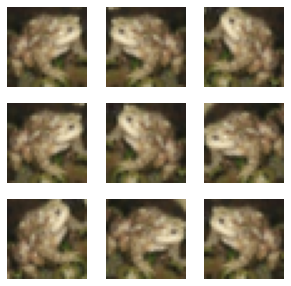

In [7]:
# Visualizing a single image
ind = 16
example = df_train[ind, : , : , : ]
print(example.shape)

# Add the image to a batch.
image = tf.cast(tf.expand_dims(example, 0), tf.float32)
print(image.shape)

plt.figure(figsize=(5, 5))
for i in range(9):
    aug_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(aug_image[0])
    plt.axis("off")

In [8]:
# Creating an empty list
df_train_aug, y_train_aug = [], []

# Iterating over all the images in the dataset
for ind in tqdm(range(df_train.shape[0])):
    if np.random.uniform() <= 0.25:
        aug_image = data_augmentation(df_train[ind, : , : , : ])
        df_train_aug.append(aug_image)
        y_train_aug.append(y_train[ind])

# Sanity Checks and Transformations
df_train_aug = np.array(df_train_aug)
y_train_aug = np.reshape(np.array(y_train_aug), (-1, 1))
y_train_aug_oh = tf.one_hot(np.ravel(y_train_aug), depth = 10)
print(df_train_aug.shape, y_train_aug.shape, y_train_aug_oh.shape)

df_aug = np.concatenate([df_train, df_train_aug], axis = 0)
y_aug = np.concatenate([y_train, y_train_aug], axis = 0)
y_aug_oh = np.concatenate([y_train_oh, y_train_aug_oh], axis = 0)
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

# Creating a random permutation
perm_aug = np.random.permutation(df_aug.shape[0])

# Shuffling the augmented dataset
df_aug = df_aug[perm_aug, : , : , : ]
y_aug = y_aug[perm_aug]
y_aug_oh = y_aug_oh[perm_aug, : ]
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

100%|██████████| 40006/40006 [01:56<00:00, 342.45it/s]


(10045, 32, 32, 3) (10045, 1) (10045, 10)
(50051, 32, 32, 3) (50051, 1) (50051, 10)
(50051, 32, 32, 3) (50051, 1) (50051, 10)


## 4.2. Training the Baseline Model on the Augmented Dataset

In [9]:
# Importing the Baseline Model Architecture
copyfile(src = "../input/dcai-rw/baseline_arch.py", dst = "../working/baseline_arch.py")
from baseline_arch import cnn_model

conv_model = cnn_model((32, 32, 3))
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Creating Batches from the Augmented Dataset
aug_dataset = tf.data.Dataset.from_tensor_slices((df_train, y_train_oh)).batch(32)
history = conv_model.fit(aug_dataset, epochs = 25)

# Saving the model along with it's weights
conv_model.save('baseline_augmented_all.h5')

Epoch 1/25
1251/1251 [==============================] - 16s 6ms/step - loss: 1.7387 - accuracy: 0.3674
Epoch 2/25
1251/1251 [==============================] - 8s 7ms/step - loss: 1.3192 - accuracy: 0.5325
Epoch 3/25
1251/1251 [==============================] - 8s 7ms/step - loss: 1.1381 - accuracy: 0.5983
Epoch 4/25
1251/1251 [==============================] - 8s 6ms/step - loss: 1.0279 - accuracy: 0.6439
Epoch 5/25
1251/1251 [==============================] - 8s 7ms/step - loss: 0.9436 - accuracy: 0.6721
Epoch 6/25
1251/1251 [==============================] - 9s 7ms/step - loss: 0.8804 - accuracy: 0.6942
Epoch 7/25
1251/1251 [==============================] - 8s 7ms/step - loss: 0.8311 - accuracy: 0.7073
Epoch 8/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.7809 - accuracy: 0.7287
Epoch 9/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.7411 - accuracy: 0.7434
Epoch 10/25
1251/1251 [==============================] - 9s 7ms/step - loss: 0.70

## 4.3. Predicting the Performance

In [10]:
# Predicting on the Train/Test Datasets
preds_train = conv_model.predict(df_train)
preds_test = conv_model.predict(df_test)

# Finding the Predicted Classes
cls_train = np.argmax(preds_train, axis = 1)
cls_test = np.argmax(preds_test, axis = 1)

# Finding the Train/Test set Loss
print("Log-loss for Train Dataset = ", log_loss(y_train_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Accuracy for Train Dataset = ", accuracy_score(y_train, cls_train))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Train Dataset =  0.2052461309473286
Log-loss for Test Dataset =  0.7576158882807598
Accuracy for Train Dataset =  0.9331100334949758
Accuracy for Test Dataset =  0.7711


- From the above analysis, we can observe that Traditional Augmentation on 25% of the Training Dataset helps to a small extent only. The **accuracy** on the test dataset has increased from **0.7692 to 0.7711** and **log-loss** on the test dataset has increased from **0.7495 from 0.7576**. 
- Now let's try to balance the dataset with the help of Traditional Augmentation Techniques, and see if it gets us any better results.

# 5. Image Augmentation for Class Balancing
## 5.1. Finding out the Class Imbalance

In [11]:
y_train_reshape = np.reshape(y_train, (-1))
num_examples = np.zeros((10,))

for i in y_train_reshape:
    num_examples[i] += 1

# Number of examples from each class
num_exa = num_examples.astype('int32')

# Finding out the maximum number of examples for any class
max_exa = max(num_exa)

# Number of examples that needs to be added to each of the classes
aug_exa = [max_exa - num_exa[i] for i in range(10)]

# Creating a list of lists for storing the indices of data-points in the training dataset, class-wise
classes_ind = []
for i in range(10):
    classes_ind.append([])

for ind, clss in enumerate(y_train_reshape):
    classes_ind[clss].append(ind)

# # Transforming list of lists into numpy array
# classes_ind = np.array([np.array(xi) for xi in classes_ind])

print(num_exa)
print(aug_exa, sum(aug_exa))
print(len(classes_ind), len(classes_ind[0]))

# Creating a list for indices of images and their labels on which augmentation needs to be done
# These are randomly chosen from each class
aug_ind = []
y_train_aug = []

for i in range(10):
    indices = random.choices(classes_ind[i], k = aug_exa[i])
    aug_ind.extend(indices)
    y_train_aug.extend([i]*aug_exa[i])

print(len(aug_ind), len(y_train_aug))

[4109 3839 4022 4116 4312 3952 4290 3552 3436 4378]
[269, 539, 356, 262, 66, 426, 88, 826, 942, 0] 3774
10 4109
3774 3774


## 5.2. Augmenting based on the Class Imbalance

In [12]:
# Creating an empty list
df_train_aug = []

for ind in tqdm(aug_ind):
    aug_image = data_augmentation(df_train[ind, : , : , : ])
    df_train_aug.append(aug_image)
    
# Sanity Checks and Transformations
df_train_aug = np.array(df_train_aug)
y_train_aug = np.reshape(np.array(y_train_aug), (-1, 1))
y_train_aug_oh = tf.one_hot(np.ravel(y_train_aug), depth = 10)
print(df_train_aug.shape, y_train_aug.shape, y_train_aug_oh.shape)

df_aug = np.concatenate([df_train, df_train_aug], axis = 0)
y_aug = np.concatenate([y_train, y_train_aug], axis = 0)
y_aug_oh = np.concatenate([y_train_oh, y_train_aug_oh], axis = 0)
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

# Creating a random permutation
perm_aug = np.random.permutation(df_aug.shape[0])

# Shuffling the augmented dataset
df_aug = df_aug[perm_aug, : , : , : ]
y_aug = y_aug[perm_aug]
y_aug_oh = y_aug_oh[perm_aug, : ]
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

100%|██████████| 3774/3774 [00:45<00:00, 83.30it/s]


(3774, 32, 32, 3) (3774, 1) (3774, 10)
(43780, 32, 32, 3) (43780, 1) (43780, 10)
(43780, 32, 32, 3) (43780, 1) (43780, 10)


In [13]:
# Finding out the number of examples in each class after augmentation
num_examples = np.zeros((10,))
for i in y_aug[:]:
    num_examples[i[0]] += 1
print(num_examples)

[4378. 4378. 4378. 4378. 4378. 4378. 4378. 4378. 4378. 4378.]


## 5.3. Training the Baseline Model on the Augmented Dataset

In [14]:
# Importing the Baseline Model Architecture
copyfile(src = "../input/dcai-rw/baseline_arch.py", dst = "../working/baseline_arch.py")
from baseline_arch import cnn_model

conv_model = cnn_model((32, 32, 3))
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Creating Batches from the Augmented Dataset
aug_dataset = tf.data.Dataset.from_tensor_slices((df_train, y_train_oh)).batch(32)
history = conv_model.fit(aug_dataset, epochs = 25)

# Saving the model along with it's weights
conv_model.save('baseline_augmented_cls_imbalance.h5')

Epoch 1/25
1251/1251 [==============================] - 9s 6ms/step - loss: 1.7300 - accuracy: 0.3719
Epoch 2/25
1251/1251 [==============================] - 8s 6ms/step - loss: 1.3205 - accuracy: 0.5332
Epoch 3/25
1251/1251 [==============================] - 8s 7ms/step - loss: 1.1344 - accuracy: 0.6039
Epoch 4/25
1251/1251 [==============================] - 8s 6ms/step - loss: 1.0245 - accuracy: 0.6471
Epoch 5/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.9465 - accuracy: 0.6724
Epoch 6/25
1251/1251 [==============================] - 9s 7ms/step - loss: 0.8918 - accuracy: 0.6930
Epoch 7/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.8394 - accuracy: 0.7094
Epoch 8/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.7989 - accuracy: 0.7270
Epoch 9/25
1251/1251 [==============================] - 8s 7ms/step - loss: 0.7496 - accuracy: 0.7408
Epoch 10/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.722

## 5.4. Predicting the Performance

In [15]:
# Predicting on the Train/Test Datasets
preds_train = conv_model.predict(df_train)
preds_test = conv_model.predict(df_test)

# Finding the Predicted Classes
cls_train = np.argmax(preds_train, axis = 1)
cls_test = np.argmax(preds_test, axis = 1)

# Finding the Train/Test set Loss
print("Log-loss for Train Dataset = ", log_loss(y_train_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Accuracy for Train Dataset = ", accuracy_score(y_train, cls_train))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Train Dataset =  0.1952733127785569
Log-loss for Test Dataset =  0.7449562801551015
Accuracy for Train Dataset =  0.9387341898715192
Accuracy for Test Dataset =  0.7669


- From the above analysis, we can observe that Traditional Augmentation for Class Balancing doesn't help at all, and if we compare the scores with those of the baseline model, we will find them lagging a bit. 
- Now, let's try to analyze the performance of the original baseline model on the non-augmented training set and test set, and depending on it's class-wise performance, we will perform augmentation on selected classes only. 

# 6. Image Augmentation based on Class-wise Performance
## 6.1. Finding out the Class-wise Performance of the Baseline Model

In [16]:
# Importing the Baseline Model
conv_model = tf.keras.models.load_model("../input/dcai-rw/baseline_model.h5")

# Predicting on the Test Datasets
preds_test = conv_model.predict(df_test)

# Finding the Predicted Classes
cls_test = np.argmax(preds_test, axis = 1)

# Finding the Test set Loss
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Test Dataset =  0.7495273496627701
Accuracy for Test Dataset =  0.7692


In [17]:
# Creating a list of lists for storing the class-wise indices of the Test Dataset
indices = []
for _ in range(10):
    indices.append([])
for ind, y in enumerate(y_test):
    indices[y[0]].append(ind)

# Creating list of lists values
y_test_cls = []
y_test_oh_cls = []
preds_test_cls = []
cls_test_cls = []

for _ in range(10):
    y_test_cls.append([])
    y_test_oh_cls.append([])
    preds_test_cls.append([])
    cls_test_cls.append([])

for ind, y in enumerate(y_test):
    label = y[0]
    y_test_cls[label].append(y_test[ind])
    y_test_oh_cls[label].append(y_test_oh[ind])
    preds_test_cls[label].append(preds_test[ind])
    cls_test_cls[label].append(cls_test[ind])

# Sanity Checks
print(len(y_test_cls), len(y_test_oh_cls), len(preds_test_cls), len(cls_test_cls))
print(len(y_test_cls[4]), len(y_test_oh_cls[3]), len(preds_test_cls[2]), len(cls_test_cls[1]))
print(len(y_test_oh_cls[3][42]), len(y_test_oh_cls[5][49]))
print()

# Finding the Class-Wise Log-loss and Accuracy on the Test Set
for i in range(10):
    print('For Class ', i)
    print("Log-loss = ", log_loss(y_test_oh_cls[i], preds_test_cls[i]))
    print("Accuracy = ", accuracy_score(y_test_cls[i], cls_test_cls[i]))
    print()

10 10 10 10
1000 1000 1000 1000
10 10

For Class  0
Log-loss =  0.6619575609589579
Accuracy =  0.838

For Class  1
Log-loss =  0.35846238857223317
Accuracy =  0.892

For Class  2
Log-loss =  1.1310175115164254
Accuracy =  0.626

For Class  3
Log-loss =  1.4357384861673446
Accuracy =  0.54

For Class  4
Log-loss =  0.7424384869041984
Accuracy =  0.764

For Class  5
Log-loss =  1.0895321149525747
Accuracy =  0.63

For Class  6
Log-loss =  0.4750614742225259
Accuracy =  0.851

For Class  7
Log-loss =  0.7093778637568552
Accuracy =  0.81

For Class  8
Log-loss =  0.5740293080587305
Accuracy =  0.836

For Class  9
Log-loss =  0.3176583015178555
Accuracy =  0.905



## 6.2. Augmenting the Train Dataset

In [18]:
# Creating a list of lists for storing the indices of data-points in the training dataset, class-wise
classes_ind = []
y_train_reshape = np.reshape(y_train, (-1))
for i in range(10):
    classes_ind.append([])
for ind, clss in enumerate(y_train_reshape):
    classes_ind[clss].append(ind)
    
# Creating a list for indices of images and their labels on which augmentation needs to be done
# These are randomly chosen from each of the underperforming classes
aug_ind = []
y_train_aug = []

# As for the under-performing classes, we will simply be choosing those classes having accuracy
# less than 80%
und_cls = [2, 3, 4, 5]

# Creating an empty list
df_train_aug, y_train_aug = [], []

# 50% Sampling
for clas in und_cls:
    for ind in tqdm(classes_ind[clas]):
        if np.random.uniform() <= 0.5:
            aug_image = data_augmentation(df_train[ind, : , : , : ])
            df_train_aug.append(aug_image)
            y_train_aug.append(y_train[ind])

# Sanity Checks and Transformations
df_train_aug = np.array(df_train_aug)
y_train_aug = np.reshape(np.array(y_train_aug), (-1, 1))
y_train_aug_oh = tf.one_hot(np.ravel(y_train_aug), depth = 10)
print(df_train_aug.shape, y_train_aug.shape, y_train_aug_oh.shape)

df_aug = np.concatenate([df_train, df_train_aug], axis = 0)
y_aug = np.concatenate([y_train, y_train_aug], axis = 0)
y_aug_oh = np.concatenate([y_train_oh, y_train_aug_oh], axis = 0)
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

# Creating a random permutation
perm_aug = np.random.permutation(df_aug.shape[0])

# Shuffling the augmented dataset
df_aug = df_aug[perm_aug, : , : , : ]
y_aug = y_aug[perm_aug]
y_aug_oh = y_aug_oh[perm_aug, : ]
print(df_aug.shape, y_aug.shape, y_aug_oh.shape)

100%|██████████| 3952/3952 [00:23<00:00, 171.13it/s]


(8314, 32, 32, 3) (8314, 1) (8314, 10)
(48320, 32, 32, 3) (48320, 1) (48320, 10)
(48320, 32, 32, 3) (48320, 1) (48320, 10)


## 6.3. Training the Baseline Model on the Augmented Dataset

In [19]:
# Importing the Baseline Model Architecture
copyfile(src = "../input/dcai-rw/baseline_arch.py", dst = "../working/baseline_arch.py")
from baseline_arch import cnn_model

conv_model = cnn_model((32, 32, 3))
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Creating Batches from the Augmented Dataset
aug_dataset = tf.data.Dataset.from_tensor_slices((df_train, y_train_oh)).batch(32)
history = conv_model.fit(aug_dataset, epochs = 25)

# Saving the model along with it's weights
conv_model.save('baseline_augmented_cls_performance_wise.h5')

Epoch 1/25
1251/1251 [==============================] - 9s 6ms/step - loss: 1.7322 - accuracy: 0.3729
Epoch 2/25
1251/1251 [==============================] - 9s 7ms/step - loss: 1.3492 - accuracy: 0.5174
Epoch 3/25
1251/1251 [==============================] - 8s 7ms/step - loss: 1.1825 - accuracy: 0.5824
Epoch 4/25
1251/1251 [==============================] - 9s 7ms/step - loss: 1.0540 - accuracy: 0.6331
Epoch 5/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.9592 - accuracy: 0.6656
Epoch 6/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.8923 - accuracy: 0.6927
Epoch 7/25
1251/1251 [==============================] - 8s 7ms/step - loss: 0.8389 - accuracy: 0.7111
Epoch 8/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.7929 - accuracy: 0.7249
Epoch 9/25
1251/1251 [==============================] - 8s 7ms/step - loss: 0.7513 - accuracy: 0.7395
Epoch 10/25
1251/1251 [==============================] - 8s 6ms/step - loss: 0.722

## 6.4. Predicting the Performance

In [20]:
# Predicting on the Train/Test Datasets
preds_train = conv_model.predict(df_train)
preds_test = conv_model.predict(df_test)

# Finding the Predicted Classes
cls_train = np.argmax(preds_train, axis = 1)
cls_test = np.argmax(preds_test, axis = 1)

# Finding the Train/Test set Loss
print("Log-loss for Train Dataset = ", log_loss(y_train_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Accuracy for Train Dataset = ", accuracy_score(y_train, cls_train))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Train Dataset =  0.20254996778692233
Log-loss for Test Dataset =  0.7750693125304731
Accuracy for Train Dataset =  0.9358596210568415
Accuracy for Test Dataset =  0.765


- From the above analysis, we can observe that Traditional Augmentation based on class-wise performance doesn't help at all too, and if we compare the scores with those of the baseline model, we will find them lagging a bit. 